<a href="https://colab.research.google.com/github/minalang/study/blob/main/210721_kaggle_bike_sharing_demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bike sharing demand
- washingtonDC에서 자전거 대여업체의 data를 통해서 자전거 수요량을 예측하는 경진대회  
### credits:
- https://www.kaggle.com/kongnyooong/bike-sharing-demand-for-korean-beginners/notebook
- https://hong-yp-ml-records.tistory.com/77?category=823206
- https://www.youtube.com/watch?v=Q_MbN-vu_2w&t=2s

### Data Fields  
- datetime - hourly date + timestamp  #날짜와 시간
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather 
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + - Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

### 순서
1. Data import and check
2. EDA
3. Feature engineering
4. Modeling and Make submission

## 1. 데이터 업로드

In [70]:
from google.colab import files
train=files.upload()
test=files.upload()
sampleSubmission=files.upload()

Saving train.csv to train (1).csv


Saving test.csv to test (1).csv


Saving sampleSubmission.csv to sampleSubmission (1).csv


1) 필요한 패키지 불러오기

In [71]:
import pandas as pd #파일불러올 떄
import numpy as np
import matplotlib as mpl #시각화
import matplotlib.pyplot as plt
import seaborn as sns #boxplot등 그래프 그릴 때 필요함
import os #디렉토리
from scipy import stats

import missingno as msno #결측치 확인할 수 있는 패키지
plt.style.use('seaborn')

import warnings #경고 무시하기
warnings.filterwarnings("ignore")

mpl.rcParams['axes.unicode_minus'] = False #마이너스 폰트가 깨지는 것을 방지

%matplotlib inline

# 기본적인 모듈을 import 합니다. 
# mlp.rcParams['axes.unicode_minus'] = False 코드는 그래프에서 마이너스 폰트가 깨지는 문제에 대한 대처입니다.

In [73]:
#pd.read_csv로 csv파일 불러오기
df_train = pd.read_csv('train.csv', parse_dates=["datetime"])
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [74]:
df_test = pd.read_csv('test.csv', parse_dates=["datetime"]) #datetime변수로 데이터 분류할거라 미리 parse
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [75]:
df_train.shape, df_test.shape #데이터 형태 확인 

((10886, 12), (6493, 9))

In [76]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


2) 결측치 확인하기

In [77]:
for col in df_train.columns:
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msperc)

column:   datetime	 Percent of NaN value: 0.00%
column:     season	 Percent of NaN value: 0.00%
column:    holiday	 Percent of NaN value: 0.00%
column: workingday	 Percent of NaN value: 0.00%
column:    weather	 Percent of NaN value: 0.00%
column:       temp	 Percent of NaN value: 0.00%
column:      atemp	 Percent of NaN value: 0.00%
column:   humidity	 Percent of NaN value: 0.00%
column:  windspeed	 Percent of NaN value: 0.00%
column:     casual	 Percent of NaN value: 0.00%
column: registered	 Percent of NaN value: 0.00%
column:      count	 Percent of NaN value: 0.00%


In [78]:
for col in df_test.columns:
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msperc)

column:   datetime	 Percent of NaN value: 0.00%
column:     season	 Percent of NaN value: 0.00%
column:    holiday	 Percent of NaN value: 0.00%
column: workingday	 Percent of NaN value: 0.00%
column:    weather	 Percent of NaN value: 0.00%
column:       temp	 Percent of NaN value: 0.00%
column:      atemp	 Percent of NaN value: 0.00%
column:   humidity	 Percent of NaN value: 0.00%
column:  windspeed	 Percent of NaN value: 0.00%


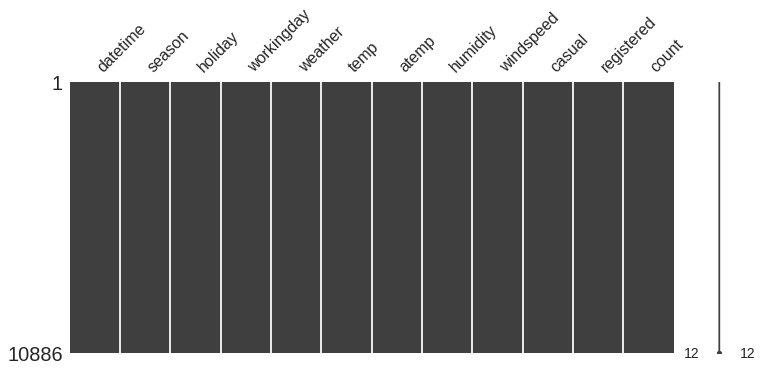

In [79]:
msno.matrix(df_train, figsize=(12,5)) #plot으로 그려 한 번 더 확인

## 2. EDA

1) 새로운 독립변수 생성

In [80]:
#train data에 새로운 독립변수 생성
df_train["year"] = df_train["datetime"].dt.year #연도
df_train["month"] = df_train["datetime"].dt.month #달
df_train["day"] = df_train["datetime"].dt.day #날짜
df_train["hour"] = df_train["datetime"].dt.hour #시간
df_train["minute"] = df_train["datetime"].dt.minute #분
df_train["second"] = df_train["datetime"].dt.second #초

#test data에 새로운 독립변수 생성
df_test["year"] = df_test["datetime"].dt.year
df_test["month"] = df_test["datetime"].dt.month
df_test["day"] = df_test["datetime"].dt.day
df_test["hour"] = df_test["datetime"].dt.hour
df_test["minute"] = df_test["datetime"].dt.minute
df_test["second"] = df_test["datetime"].dt.second

df_train.shape #모양 확인

# datetime의 데이터들을 편하게 알아보기위해 년,월,일,시,분,초 단위로 나눠준다.
# 확인결과 column이 12개에서 18로 늘어난것을 볼 수 있다.

(10886, 18)

2) barplot을 통한 시각화

[Text(0, 0.5, 'count'), Text(0.5, 1.0, 'Rental amount by hour')]

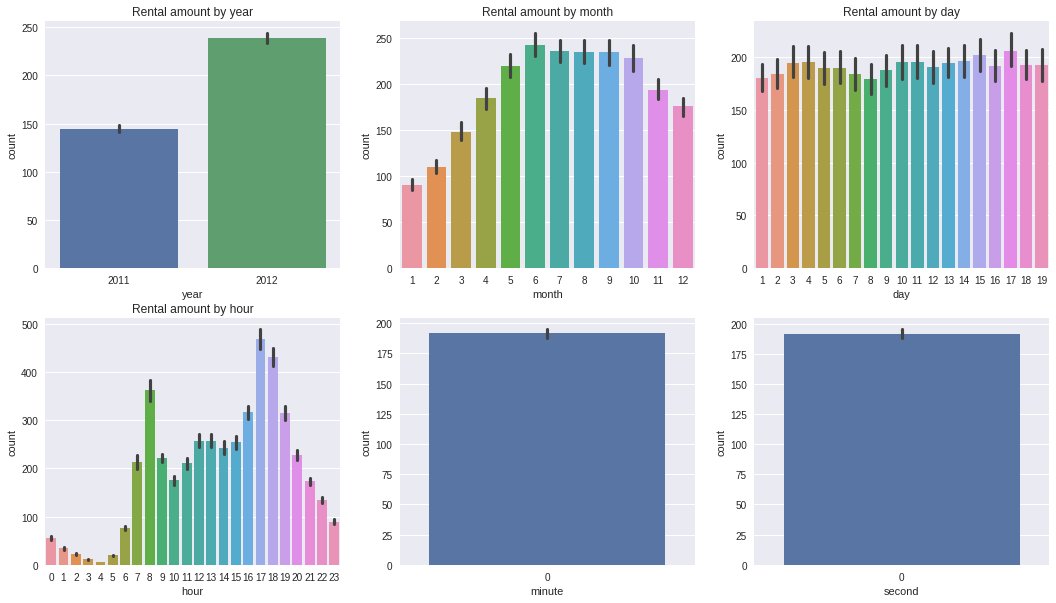

In [81]:
figure, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows = 2, ncols = 3)
figure.set_size_inches(18,10)

sns.barplot(data=df_train, x = "year", y = "count", ax = ax1)
sns.barplot(data=df_train, x = "month", y = "count", ax = ax2)
sns.barplot(data=df_train, x = "day", y = "count", ax = ax3)
sns.barplot(data=df_train, x = "hour", y = "count", ax = ax4)
sns.barplot(data=df_train, x = "minute", y = "count", ax = ax5)
sns.barplot(data=df_train, x = "second", y = "count", ax = ax6)

ax1.set(ylabel = "count", title = "Rental amount by year")
ax2.set(ylabel = "count", title = "Rental amount by month")
ax3.set(ylabel = "count", title = "Rental amount by day")
ax4.set(ylabel = "count", title = "Rental amount by hour")

# 각 기준별 대여량을 직관적으로 살펴보기 위해 barplot을 사용하여 시각화 해줍니다.
# 연도별 대여량을 보면 11년도보다 12년도가 대여량이 늘어난것을 알 수 있습니다. 
# 월별 대여량을 보면 대체로 겨울보다 여름에 대여량이 높은것으로 보입니다.
# 일별 대여량은 1~19일까지의 데이터만 포함된다. 나머지는 test데이터에 있으며 일단 보류하도록 합니다.
# 시간별 대여량은 오전8시와 오후5시, 오후6시 가량이 높은데, 출퇴근시간에 이용하는 고객이 많아서 그런것으로 판단됩니다.

###### 분석
- 연도별 대여량: 2011년 보다 2012년도에 대여량이 늘어났다
- 월별 대여량: 겨울보다 여름에 대여량이 높다
- 일별 대여량: 1~19일 까지의 데이터만 포함. 나머지는 test데이터에 있으므로 보류
- 시간별 대여량: 오전8시와 오후 5시, 오후 6시 가량이 높은데 이는 출퇴근시간에 이용하는 고객이 많아서 그런것으로 판단됨

In [82]:
#요일 변수 추가생성
df_train["dayofweek"] = df_train["datetime"].dt.dayofweek
df_test["dayofweek"] = df_test["datetime"].dt.dayofweek
df_train.shape

# 요일 변수를 추가로 생성해줍니다. 
# 제대로 생성되어 column의 수가 19개로 늘어났습니다.

(10886, 19)

In [83]:
df_train["dayofweek"].value_counts()

# 0~6까지의 범주의 갯수를 세어줍니다. 
# 0 = 월요일 ~ 6 = 일요일입니다.
# 5,6(토, 일)의 대여량이 조금더 많은 것으로 보아 앞서 살펴본 workingday의 Boxplot 내용과 어느정도 일치하는 것으로 보입니다.

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

3) point plot을 통한 시각화

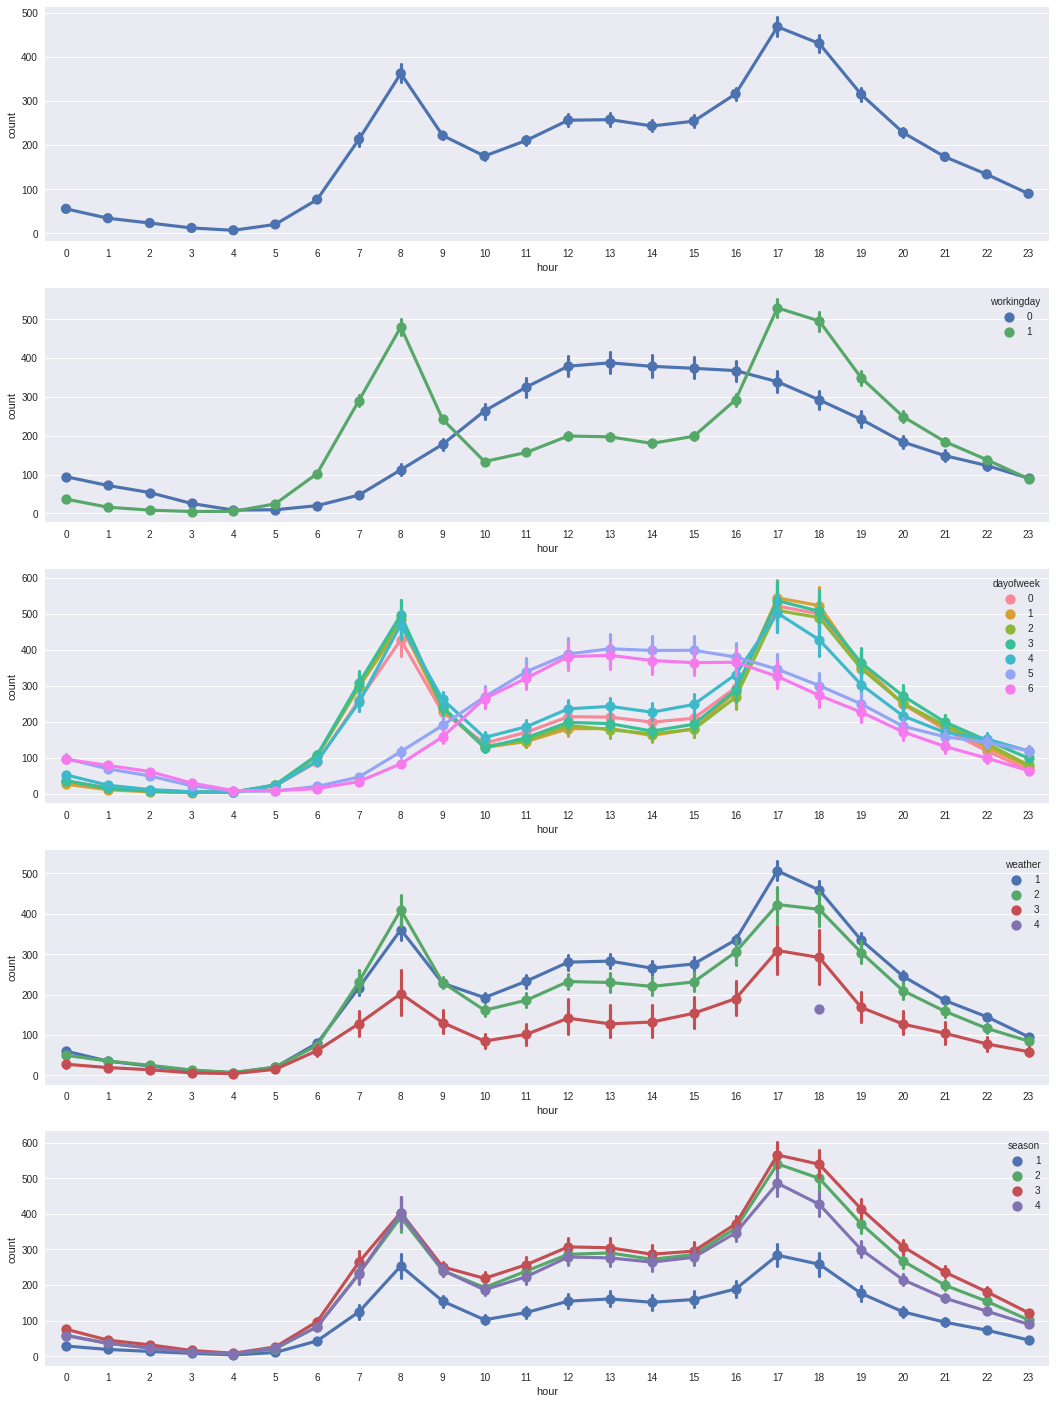

In [84]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 5)
fig.set_size_inches(18,25)

sns.pointplot(data = df_train, x = "hour", y = "count", ax = ax1)
sns.pointplot(data = df_train, x = "hour", y = "count", hue = "workingday", ax = ax2)
sns.pointplot(data = df_train, x = "hour", y = "count", hue = "dayofweek", ax = ax3)
sns.pointplot(data = df_train, x = "hour", y = "count", hue = "weather", ax = ax4)
sns.pointplot(data = df_train, x = "hour", y = "count", hue = "season",  ax = ax5)

# 시간의 흐름에 따른 pointplot을 그려줍니다.
# 첫번째 plot은 역시 앞서 보았던 결과들과 일치합니다.
# 두번째 plot을 보면 근무일때는 출퇴근시간에 집중되어 있지만, 아닌 경우는 그래프가 낮시간에 전체적으로 평이합니다. 
# 세번째 plot을 보면 역시 두번째 plot과 마찬가지로 토,일은 낮시간에 전체적으로 평이하고, 나머지 요일은 출퇴근 시간에 집중됩니다.
# 네번째 plot을 보면 맑은날이 역시 가장 높은 대여량을 보이고, 그 다음으로 안개, 가벼운 눈비가 오늘 날씨순으로 대여량이 많습니다. 악천후인 날씨는 없다고 봐도 무방할 정도입니다.
# 마지막 plot을 보면 봄이 가장적으며, 여름 가을 겨울은 조금의 차이가 나는 것으로 보입니다.

##### point plot으로 시각화
- 첫번째 plot은 8시와 17시, 18시에 사용량이 늘어난다는 것을 보여줌: 출퇴근시간 반영
- 두번째 plot은 workingday(1)일 때는 사용량의 정도가 출퇴근시간에 밀집되어있다는 것을 볼 수 있지만 workingday가 아닌 경우(0)에서는 낮시간 동안에 사용량이 비슷하다는 것을 볼 수 있음
- 세번째 plot은 토, 일(5, 6)은 낮시간에 평이하고, 평일(0~4)는 출퇴근시간에 영향을 받는다
- 네번째 plot은 맑은 날(1)일때 가장 사용량이 많고 악천후일 때는 거의 사용량이 없다고 봐도 무방함
- 다섯번째 plot을 보면 봄(1)일 때 사용량이 가장 적으며, 나머지는 유사하며, 가을에 가장 사용량이 많은 것을 볼 수 있음

4) 히트맵을 통한 시각화

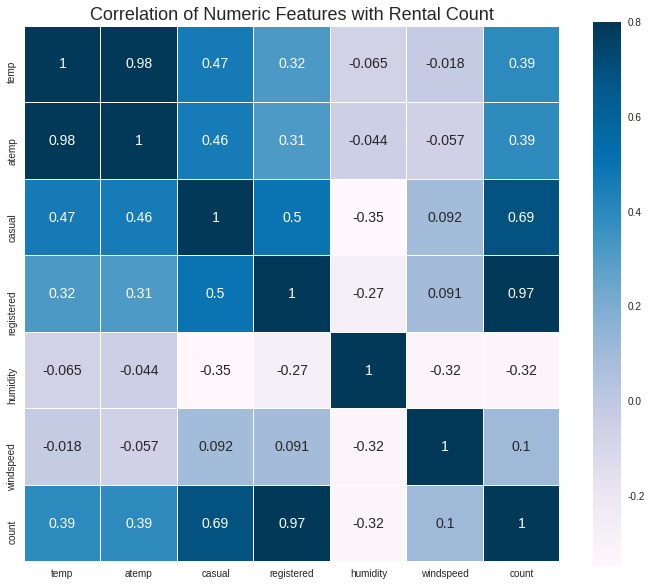

In [85]:
corr_data = df_train[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]]

colormap = plt.cm.PuBu
 
f , ax = plt.subplots(figsize = (12,10))
plt.title('Correlation of Numeric Features with Rental Count',y=1,size=18)
sns.heatmap(corr_data.corr(), vmax=.8, linewidths=0.1,square=True,annot=True,cmap=colormap,
            linecolor="white",annot_kws = {'size':14})

# 수치형 데이터들의 상관관계를 알아보기위해 Heatmap을 그려봅니다.
# count의 열을 보면 가장 눈에 띄게 진한 변수는 registered입니다. 이 변수는 test데이터엔 존재하지 않습니다.
# 그 다음으로 상관계수가 높은 변수는 casual이다.
# 온도, 습도, 풍속은 거의 관계가 없다고 볼 수 있다.
# temp와 atemp는 온도, 체감온도인데 상관계수가 매우 높은걸로 봐서 다중공선성을 보인다고 할 수 있다.
# atemp: 내가 어떻게 날씨를 느끼는지
# 다중공산성: 독립변수간의 영향이 크다

##### 히트맵으로 시각화
- count의 열을 보면 가장 눈에 띄게 진한 변수는 registered(예약하여 사용하였는지 이 변수는 test데이터엔 존재하지 않음
- 그 다음으로 상관계수가 높은 변수는 casual
- 온도, 습도, 풍속은 거의 관계가 없다고 볼 수 있음
- temp와 atemp는 온도, 체감온도인데 상관계수가 매우 높은걸로 봐서 다중공선성을 보인다고 할 수 있다.
- atemp: 내가 어떻게 날씨를 느끼는지
- 다중공산성: 독립변수간의 영향이 크다

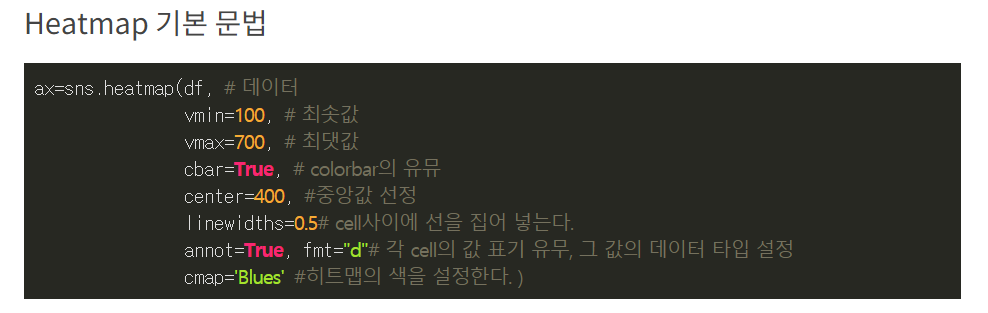

5) 히트맵에서 관계도가 적었던 temp, windspeed, humidity에 대한 plotting

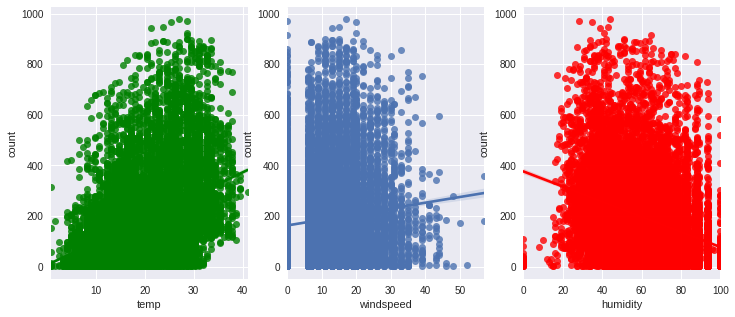

In [86]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize=(12,5))

temp_scatter_plot = pd.concat([df_train['count'],df_train['temp']],axis = 1)
sns.regplot(x='temp',y = 'count',data = temp_scatter_plot,scatter= True, fit_reg=True, ax=ax1, color="green")
windspeed_scatter_plot = pd.concat([df_train['count'],df_train['windspeed']],axis = 1)
sns.regplot(x='windspeed',y = 'count',data = windspeed_scatter_plot,scatter= True, fit_reg=True, ax=ax2)
humidity_scatter_plot = pd.concat([df_train['count'],df_train['humidity']],axis = 1)
sns.regplot(x='humidity',y = 'count',data = humidity_scatter_plot,scatter= True, fit_reg=True, ax=ax3, color="red")

# 유의하지 않다고 판단된 변수에 대해서 Scatterplot을 그려봅니다.
# windspeed의 경우 0에 많은 데이터가 몰려있습니다. 
# 일반적으로 풍속이 0인 경우가 흔치 않으므로 Null데이터를 0으로 대체한게 아닌가 생각해볼 수 있습니다. 

- 유의하지 않다고 판단된 변수에 대해서 Scatterplot을 그려봅니다.
- windspeed의 경우 0에 많은 데이터가 몰려있습니다. 
- 일반적으로 풍속이 0인 경우가 흔치 않으므로 Null데이터를 0으로 대체한게 아닌가 생각해볼 수 있습니다. 

7) 그 중 풍속에 대한 값 시각화

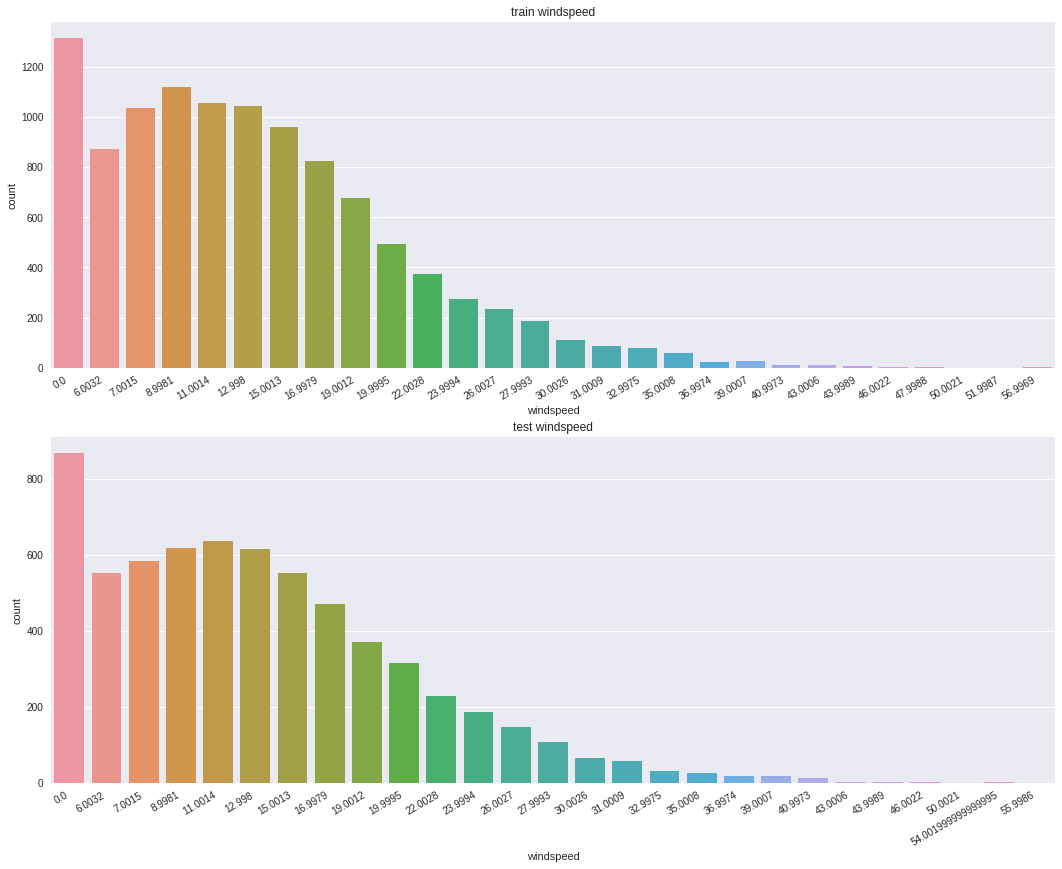

In [87]:
fig, axes = plt.subplots(nrows = 2, figsize = (18,14))

plt.sca(axes[0])
plt.xticks(rotation = 30, ha = "right")
axes[0].set(ylabel = "count", title = "train windspeed")
sns.countplot(data = df_train, x = "windspeed", ax = axes[0])

plt.sca(axes[1])
plt.xticks(rotation = 30, ha = "right")
axes[1].set(ylabel = "count", title = "test windspeed")
sns.countplot(data = df_test, x = "windspeed", ax = axes[1])

# 풍속에 대한 자세한 시각화를 해준다.
# 0에대한 값이 매우많다.
# Feature engineering에서 고쳐주도록 한다.

0이 매우 많기 때문에 feature engineering에서 고쳐줄 것

8) 대여변화를 좀 더 자세히 보기 위해 year과 month데이터를 붙여준다

In [ ]:
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

df_train["year_month"] = df_train["datetime"].apply(concatenate_year_month)
df_test["year_month"] = df_test["datetime"].apply(concatenate_year_month) 
    
print(df_train.shape)
df_train[["datetime", "year_month"]].head()

# 연도별 데이터의 대여 변화를 좀더 자세히 보기위해 year와 month 데이터를 붙여줍니다. 

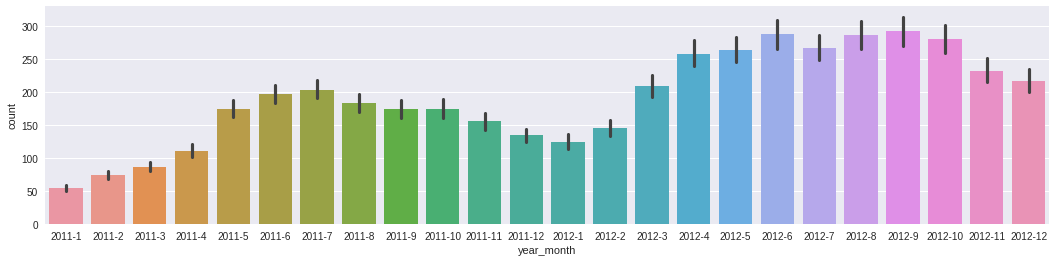

In [89]:
fig, ax = plt.subplots(figsize = (18,4))

sns.barplot(data = df_train, y = "count", x = "year_month")

# 2011년에 비해 2012년의 대여량이 높아졌던것을 확인했었는데, 두 년도를 월별로 시각화하여 좀 더 연속적으로 보도록합니다.
# 역시나 2012년의 대여량이 대체적으로 높으며, 두 연도 모두 따뜻한 계절의 대여량이 더 높습니다.
# 전체적으로 보면 갈수록 대여량이 증가하는 추세입니다.
# 여름에 자전거 대여량이 많은걸 알 수 있다. 

- 2011년에 비해 2012년의 대여량이 높아졌던것을 확인했었는데, 두 년도를 월별로 시각화하여 좀 더 연속적으로 봄.
-  2012년의 대여량이 대체적으로 높으며, 두 연도 모두 따뜻한 계절의 대여량이 더 높습니다.
- 전체적으로 보면 갈수록 대여량이 증가하는 추세
- 여름에 자전거 대여량이 많은걸 알 수 있다. 

9) 이상치 제거

In [90]:
from collections import Counter 

def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        #이상치 기준. 3사분위*1.5 보다 크면 이상치로 탐지하겠다
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers
        
Outliers_to_drop = detect_outliers(df_train, 2, ["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"])

# train 데이터의 이상치를 탐색합니다.
# IQR(튜키의 방법)을 이용한 함수를 지정하여 이상치 탐색을 수행합니다.

In [91]:
#참고하기
'''
import numpy as np
from collections import Counter


def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers
#리스트에 붙여서 그 개수가 n=2보다 크면 outliers to drop 에 저장한다.
# detect outliers from list of features
lof = ['example_feature_1', 'example_feature_2']
# params dataset, number of outliers for rejection, list of features
Outliers_to_drop = detect_outliers(dataset, 2, lof)
'''

'\nimport numpy as np\nfrom collections import Counter\n\n\ndef detect_outliers(df, n, features):\n    """\n    Takes a dataframe df of features and returns a list of the indices\n    corresponding to the observations containing more than n outliers according\n    to the Tukey method.\n    """\n    outlier_indices = []\n\n    # iterate over features(columns)\n    for col in features:\n        # 1st quartile (25%)\n        Q1 = np.percentile(df[col], 25)\n        # 3rd quartile (75%)\n        Q3 = np.percentile(df[col], 75)\n        # Interquartile range (IQR)\n        IQR = Q3 - Q1\n\n        # outlier step\n        outlier_step = 1.5 * IQR\n\n        # Determine a list of indices of outliers for feature col\n        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index\n\n        # append the found outlier indices for col to the list of outlier indices \n        outlier_indices.extend(outlier_list_col)\n\n    # select observations containing more t

1Q-IQR*1.5한 값(outlier step)보다 작거나  
3Q+IQR*105한 값보다 크면 이상치로 간주한다.  
그 값을 list에 넣어주고, 그 개수가 n=2보다 크면 outliers to drop 에 저장하는 것으로 한다.

In [92]:
df_train.loc[Outliers_to_drop] #year-month붙인 열 하나 더 생성해서 열이 20개로 늘었음

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek,year_month
6658,2012-03-14 17:00:00,1,0,1,1,28.70,31.820,28,6.0032,140,642,782,2012,3,14,17,0,0,2,2012-3
6779,2012-03-19 18:00:00,1,0,1,1,26.24,31.060,57,16.9979,120,681,801,2012,3,19,18,0,0,0,2012-3
6825,2012-04-02 17:00:00,2,0,1,1,20.50,24.240,29,19.0012,128,601,729,2012,4,2,17,0,0,0,2012-4
6849,2012-04-03 17:00:00,2,0,1,1,25.42,30.305,17,12.9980,123,634,757,2012,4,3,17,0,0,1,2012-4
6850,2012-04-03 18:00:00,2,0,1,1,24.60,30.305,26,11.0014,139,661,800,2012,4,3,18,0,0,1,2012-4
6897,2012-04-05 17:00:00,2,0,1,1,20.50,24.240,31,11.0014,145,677,822,2012,4,5,17,0,0,3,2012-4
7088,2012-04-13 17:00:00,2,0,1,1,22.96,26.515,24,11.0014,117,621,738,2012,4,13,17,0,0,4,2012-4
7640,2012-05-17 17:00:00,2,0,1,1,27.06,31.060,31,8.9981,133,719,852,2012,5,17,17,0,0,3,2012-5
7641,2012-05-17 18:00:00,2,0,1,1,27.06,31.060,27,11.0014,134,734,868,2012,5,17,18,0,0,3,2012-5
7664,2012-05-18 17:00:00,2,0,1,1,27.06,31.060,34,8.9981,124,688,812,2012,5,18,17,0,0,4,2012-5


이상치 값들 확인

10) 이상치를 제거한 데이터 개수 확인

In [93]:
df_train = df_train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
df_train.shape

(10846, 20)

11) 데이터의 첨도와 왜도 확인

In [94]:
df_train_num = df_train[["count", "temp", "atemp", "casual", "registered", "humidity", "windspeed"]]

for col in df_train_num:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(df_train[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(df_train[col].kurt())  
         )

# 왜도(skewness, 데이터 중심이 얼마나 치우쳐있는지 음일때 왼쪽으로), 첨도(kurtosis, 첨도가 크면 이상치가 많다.) 

count           Skewness: 01.21     Kurtosis: 001.20
temp            Skewness: 00.01     Kurtosis: -00.91
atemp           Skewness: -0.10     Kurtosis: -00.85
casual          Skewness: 02.52     Kurtosis: 007.74
registered      Skewness: 01.51     Kurtosis: 002.61
humidity        Skewness: -0.09     Kurtosis: -00.76
windspeed       Skewness: 00.58     Kurtosis: 000.63


- 왜도(skewness)
  - 분포가 정규분포에 비해 얼마나 치우쳐있는지. 음일때 왼쪽으로), 
  - 절댓값 3보다 작으면 기준에 부합함. -2~2사이면 왜도가 크지않다
- 첨도(kurtosis) 
  - 샘플이 평균을 중심으로 가까이 몰려있을수록 첨도가 커진다(뾰족해진다)
  - 데이터가 얼마나 퍼져있는지를 의미(=분산)
  - 첨도가 0보다 크면 정규분포보다 데이터가 중심으로 몰려있는것. 0보다 작으면 정규분포보다 분포의 높이가 정규분포보다 낮은 저첨이 된다.
  - 첨도가 크면 이상값이 많다  

- 왜도 절댓값3미만, 첨도 절댓값 7 미만이면 기분에 부합하는 것으로 본다  

credits: https://m.blog.naver.com/yk60park/222100758577 

12) 데이터에 대한 boxplot 시각화

[Text(0, 0.5, 'count'), Text(0.5, 1.0, 'Rental count by minute')]

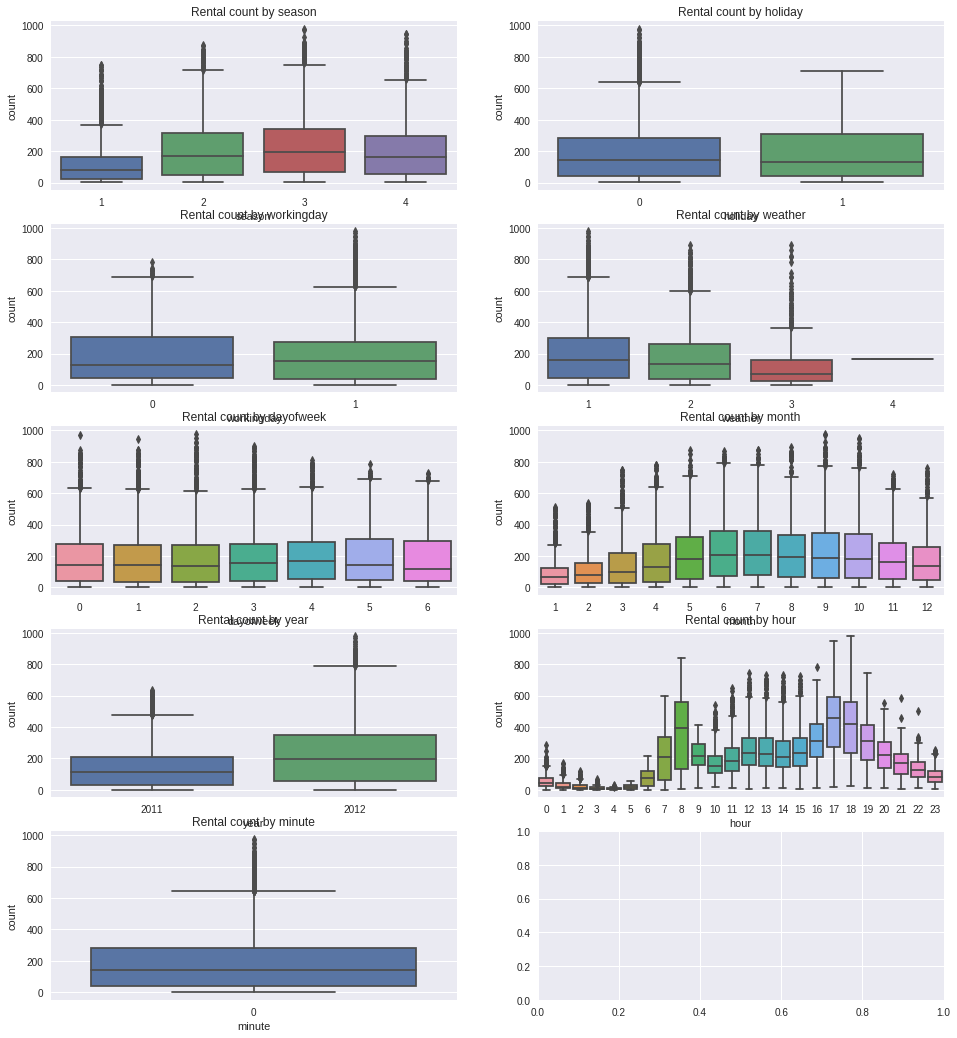

In [95]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize=(16, 18))
sns.boxplot(data = df_train, y="count", x = "season", orient = "v", ax = axes[0][0]) #h는 horizen, v는 vertical(세로방향)
sns.boxplot(data = df_train, y="count", x = "holiday", orient = "v", ax = axes[0][1])
sns.boxplot(data = df_train, y="count", x = "workingday", orient = "v", ax = axes[1][0])
sns.boxplot(data = df_train, y="count", x = "weather", orient = "v", ax = axes[1][1])
sns.boxplot(data = df_train, y="count", x = "dayofweek", orient = "v", ax = axes[2][0])
sns.boxplot(data = df_train, y="count", x = "month", orient = "v", ax = axes[2][1])
sns.boxplot(data = df_train, y="count", x = "year", orient = "v", ax = axes[3][0])
sns.boxplot(data = df_train, y="count", x = "hour", orient = "v", ax = axes[3][1])
sns.boxplot(data = df_train, y="count", x = "minute", orient = "v", ax = axes[4][0])

axes[0][0].set(ylabel = "count", title = "Rental count by season")
axes[0][1].set(ylabel = "count", title = "Rental count by holiday")
axes[1][0].set(ylabel = "count", title = "Rental count by workingday")
axes[1][1].set(ylabel = "count", title = "Rental count by weather")
axes[2][0].set(ylabel = "count", title = "Rental count by dayofweek")
axes[2][1].set(ylabel = "count", title = "Rental count by month")
axes[3][0].set(ylabel = "count", title = "Rental count by year")
axes[3][1].set(ylabel = "count", title = "Rental count by hour")
axes[4][0].set(ylabel = "count", title = "Rental count by minute")

## 2. feature engineering

1) 타겟변수인 count의 첨도와 왜도 확인

Skewness: 1.210923
Kurtosis: 1.200871


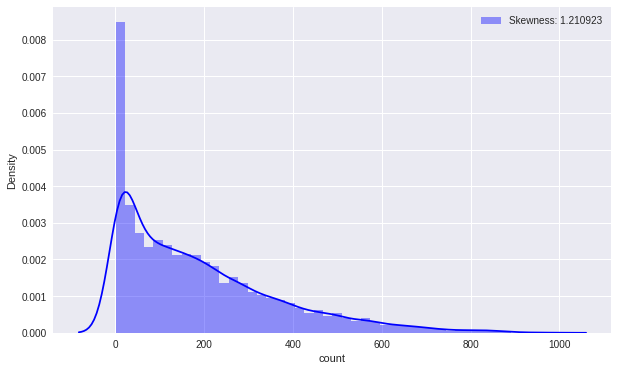

In [96]:
#타겟변수인 count의 
f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(df_train["count"], color = "b", label="Skewness: {:2f}".format(df_train["count"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % df_train["count"].skew())
print("Kurtosis: %f" % df_train["count"].kurt())


마지막으로 타겟변수인 count의 Skewness와 Kurtosis (첨도&왜도)를 확인해보겠습니다.

Skewness(비대칭도)란 분포가 얼마나 비대칭을 띄는가 알려주는 척도입니다.

(비대칭도: a=0이면 정규분포, a<0 이면 오른쪽으로 치우침, a>0이면 왼쪽으로 치우침)

Kurtosis (첨도)란 확률분포의 뾰족한 정도를 나타내는 척도입니다.

관측치들이 어느 정도 집중적으로 중심에 몰려 있는가를 측정할 때 사용됩니다.


그래프에 치우침이 보이는 것을 확인할 수 있습니다. 

count 대부분의 데이터가 0에 몰려있는 모습인데요, Feature Engineering 단계에서 자세히 알아보도록 하겠습니다.

credits: https://hong-yp-ml-records.tistory.com/17?category=823206 [HONG YP's Data Science BLOG]

2) 타겟변수인 count에 log를 취해주어 0으로 치우친 것을 해소해주었음

Skewness: -0.975198
Kurtosis: 0.247435


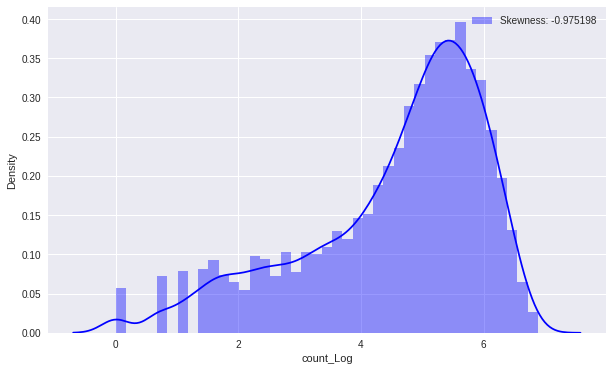

In [97]:
df_train["count_Log"] = df_train["count"].map(lambda i:np.log(i) if i>0 else 0)

f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(df_train["count_Log"], color = "b", label="Skewness: {:2f}".format(df_train["count_Log"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % df_train['count_Log'].skew())
print("Kurtosis: %f" % df_train['count_Log'].kurt())

df_train.drop('count', axis= 1, inplace=True)

# 치우침 해소를위해 로그를 취한다.

3) 풍속에 대한 변수 수정

In [98]:
trainWind0 = df_train.loc[df_train["windspeed"] == 0]
trainWindNot0 = df_train.loc[df_train["windspeed"] != 0]

# 풍속 변수의 0값 데이터들을 만져주기 위해 0인 값과 아닌 값들로 나눠줍니다.

- 풍속이 0일수가 없는데, 0으로 표기되었다는건 측정하지 못했거나 측정기에 null이 되서 0으로 표기할 수 있음.  
- 따라서, 풍속이 0이 아닌 값들을 분류해서 그 데이터들로 예측기를 만들고, 그걸 기반으로 0으로 적혀진 부분에 풍속을 예측해서 결측값을 채워넣어줌

In [99]:
from sklearn.ensemble import RandomForestClassifier
# RandomForest로 값을 예측해보도록 합니다.
def predict_windspeed(data):
    dataWind0 = data.loc[data["windspeed"] == 0]
    dataWindNot0 = data.loc[data["windspeed"] != 0]
    # 풍속 데이터를 0인 값과 아닌 값들로 나눠줍니다.
    wcol = ["season", "weather", "humidity", "day", "temp", "atemp"]
    # 예측에 필요한 변수들을 지정합니다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")
    # 풍속이 0이 아닌 값들을 string데이터로 변환합니다.
    rf_wind = RandomForestClassifier()
    rf_wind.fit(dataWindNot0[wcol], dataWindNot0["windspeed"])
    wind0 = rf_wind.predict(X=dataWind0[wcol])
    # 랜덤포레스트를 사용하여 wcol의 변수들로 0인 값들을 학습시키고 예측합니다.
    
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    # 예측한 값을 넣어줄 데이터프레임을 만듭니다.
    predictWind0["windspeed"] = wind0
    # 예측값들을 넣어줍니다.
    data = predictWindNot0.append(predictWind0)
    # 0이 아닌 데이터들과 예측값들을 합쳐줍니다.
    data["windspeed"] = data["windspeed"].astype("float")
    # 풍속의 데이터들을 다시 float 타입으로 변환합니다.
    data.reset_index(inplace = True)
    data.drop("index", inplace = True, axis = 1)
    
    return data
    

randomforest classifier를 통해 풍속이 0이 아닌 관측치들을 따로 분류하여 독립변수에 대한 풍속값을 학습함(마치 train data). 그리고 풍속이 0인 데이터에 학습한 것을 바탕으로 풍속을 예측하여 결과값을 채워줌(마치 test data)

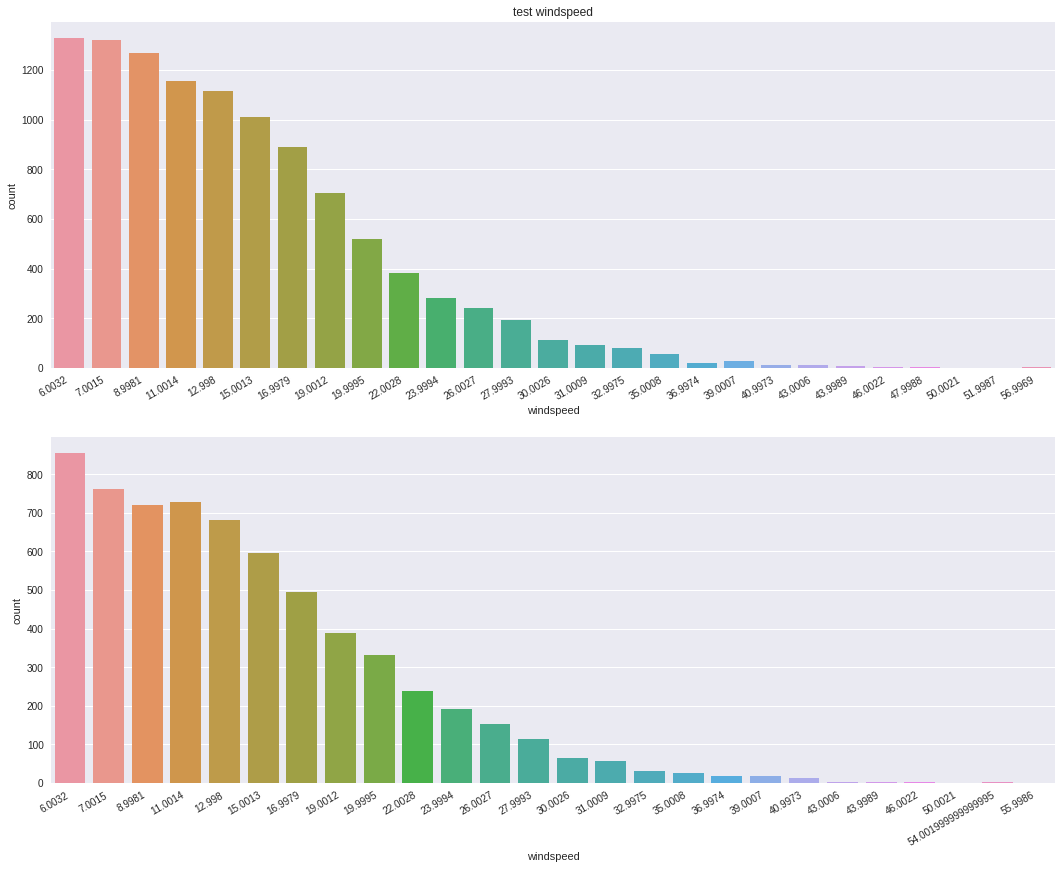

In [100]:
df_train = predict_windspeed(df_train)
df_test = predict_windspeed(df_test)

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (18,14))

plt.sca(ax1)
plt.xticks(rotation = 30, ha = "right")
ax1.set(ylabel = "count", title = "train windspeed")
sns.countplot(data = df_train, x = "windspeed", ax = ax1)

plt.sca(ax2)
plt.xticks(rotation = 30, ha = "right")
ax1.set(ylabel = "count", title = "test windspeed")
sns.countplot(data = df_test, x = "windspeed", ax = ax2)

# 예측된 풍속데이터 시각화, 

0이 예측값으로 모두 대체된 것을 확인할 수 있음

4) log를 취해준 타겟변수와 0값을 채워준 풍속데이터틔 상관계수 확인

In [102]:
corr_data = df_train[["count_Log", "windspeed"]]
corr_data.corr()

,count_Log,windspeed
count_Log,1.000000,0.124229
windspeed,0.124229,1.000000


5) categorical feature one hot encoding하기

In [101]:
df_train = pd.get_dummies(df_train, columns = ["weather"], prefix = "weather")
df_test = pd.get_dummies(df_test, columns = ["weather"], prefix = "weather")

df_train = pd.get_dummies(df_train, columns = ["season"], prefix = "season")
df_test = pd.get_dummies(df_test, columns = ["season"], prefix = "season")

#onehotencoding

6) 필요하지 않은 변수는 데이터에서 제거해주기

In [103]:
datetime_test = df_test['datetime']

df_train.drop(["datetime", "registered","casual","holiday", "year_month", "minute", "second"], axis = 1, inplace = True)
df_test.drop(["datetime","holiday", "year_month", "minute", "second"], axis = 1, inplace = True)

In [104]:
df_train.head()

,workingday,temp,atemp,humidity,windspeed,year,month,day,hour,dayofweek,count_Log,weather_1,weather_2,weather_3,weather_4,season_1,season_2,season_3,season_4
0,0,9.84,12.880,75,6.0032,2011,1,1,5,5,0.000000,0,1,0,0,1,0,0,0
1,0,15.58,19.695,76,16.9979,2011,1,1,10,5,3.583519,1,0,0,0,1,0,0,0
2,0,14.76,16.665,81,19.0012,2011,1,1,11,5,4.025352,1,0,0,0,1,0,0,0
3,0,17.22,21.210,77,19.0012,2011,1,1,12,5,4.430817,1,0,0,0,1,0,0,0
4,0,18.86,22.725,72,19.9995,2011,1,1,13,5,4.543295,0,1,0,0,1,0,0,0


In [105]:
df_test.head(20)

,workingday,temp,atemp,humidity,windspeed,year,month,day,hour,dayofweek,weather_1,weather_2,weather_3,weather_4,season_1,season_2,season_3,season_4
0,1,10.66,11.365,56,26.0027,2011,1,20,0,3,1,0,0,0,1,0,0,0
1,1,10.66,12.880,56,11.0014,2011,1,20,3,3,1,0,0,0,1,0,0,0
2,1,10.66,12.880,56,11.0014,2011,1,20,4,3,1,0,0,0,1,0,0,0
3,1,9.84,11.365,60,15.0013,2011,1,20,5,3,1,0,0,0,1,0,0,0
4,1,9.02,10.605,60,15.0013,2011,1,20,6,3,1,0,0,0,1,0,0,0
5,1,9.02,10.605,55,15.0013,2011,1,20,7,3,1,0,0,0,1,0,0,0
6,1,9.02,10.605,55,19.0012,2011,1,20,8,3,1,0,0,0,1,0,0,0
7,1,9.84,11.365,52,15.0013,2011,1,20,9,3,0,1,0,0,1,0,0,0
8,1,10.66,11.365,48,19.9995,2011,1,20,10,3,1,0,0,0,1,0,0,0
9,1,11.48,13.635,45,11.0014,2011,1,20,11,3,0,1,0,0,1,0,0,0


## 3. 모델만들기&제출하기

1) train data와 test data불러오고 train data는 다시 validation데이터 분류해주기

In [107]:
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
X_train = df_train.drop("count_Log", axis = 1).values 
target_label = df_train["count_Log"].values 
# 타겟변수인 count_Log를 제외한 나머지 변수를 x_train에, count_Log값을 target_label이라는 변수에 새롭게 저장
X_test = df_test.values 
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size = 0.2, random_state = 2000) 
#돌릴때마다 결과가 다르게 나오지않게 고정
#검증데이터 훈련데이터의 0.2

2) gradient boosting regressor모델 사용해 학습
- 여러개의 결정트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법
- 회귀와 분류에 모두 사용할 수 있음
- 랜덤포레스트와 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다.
- 무작위성이 없고 강력한 사전 가지치기가 사용 됨
- 1~5개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름
- learning_rate : 오차를 얼마나 강하게 보정할 것인지를 제어
- n_estimator의 값을 키우면 앙상블에 트리가 더 많이 추가 되어 모델의 복잡도가 커지고 훈련세트에서의 실수를 바로잡을 기회가 많아지지만 너무 크면 모델이 복잡해지고 오버피팅(과대적합)이 될 수있다.
- max_depth(max_leaf_nodes) 복잡도를 너무 높이지 말고 트리의 깊이가 5보다 깊어지지 않게 한다.

In [108]:
from sklearn.ensemble import GradientBoostingRegressor
regressor = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.05,
                                   max_depth=4, 
                                   min_samples_leaf=15, min_samples_split=10, random_state =42) 

regressor.fit(X_tr,y_tr)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=2000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

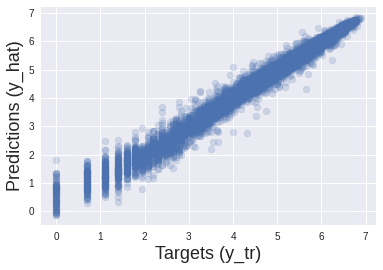

In [109]:
y_hat = regressor.predict(X_tr)
plt.scatter(y_tr, y_hat, alpha = 0.2)
plt.xlabel('Targets (y_tr)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.show()

얼마나 잘 접합되었는지 확인

3) 검증데이터에 예측

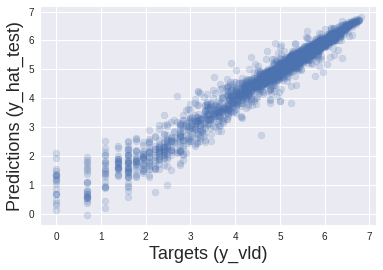

In [110]:
y_hat_test = regressor.predict(X_vld)
plt.scatter(y_vld, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_vld)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.show()

4) Test데이터 통해서 예측

In [111]:
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification

models=[GradientBoostingRegressor()]
model_names=['regressor']
rmsle=[]
d={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(X_tr,y_tr)
    test_pred=clf.predict(X_vld)
    rmsle.append(np.sqrt(mean_squared_log_error(test_pred,y_vld)))
d={'Modelling Algo':model_names,'RMSLE':rmsle}   
d

{'Modelling Algo': ['regressor'], 'RMSLE': [0.13359193189939442]}

5) 예측 정확도 확인

In [112]:
from sklearn.model_selection import cross_val_score 
accuracies = cross_val_score(estimator = regressor, X = X_tr, y = y_tr, cv = 8)

In [113]:
print(accuracies.mean()) #95%정확도 보임
print(accuracies.std())

0.9565881522536765
0.00370051467921128


In [114]:
use_logvals = 1 

pred_xgb = regressor.predict(X_test) 

sub_xgb = pd.DataFrame() 
sub_xgb['datetime'] = datetime_test 
sub_xgb['count'] = pred_xgb 
if use_logvals == 1:
    sub_xgb['count'] = np.exp(sub_xgb['count'])
    
sub_xgb.to_csv('xgb.csv',index=False)

- 만들어준 모델로 테스트 셋을 예측하고 submission파일로 만들어서 제출

- 여기서 중요한 것은 log를 취해주었던 타겟변수에 다시 exp를 취해주어 원래의 값으로 돌려놓는 것입니다. 

- 커널을 저장해주고 제출을 해봅니다.

- 알아두어야할 점은 Bike Sharing Demand 대회는 예전에 끝난 대회이기 때문에 따로 csv 파일을 업로드하여 제출을 진행해야합니다. 

credits: https://hong-yp-ml-records.tistory.com/77?category=823206 [HONG YP's Data Science BLOG]

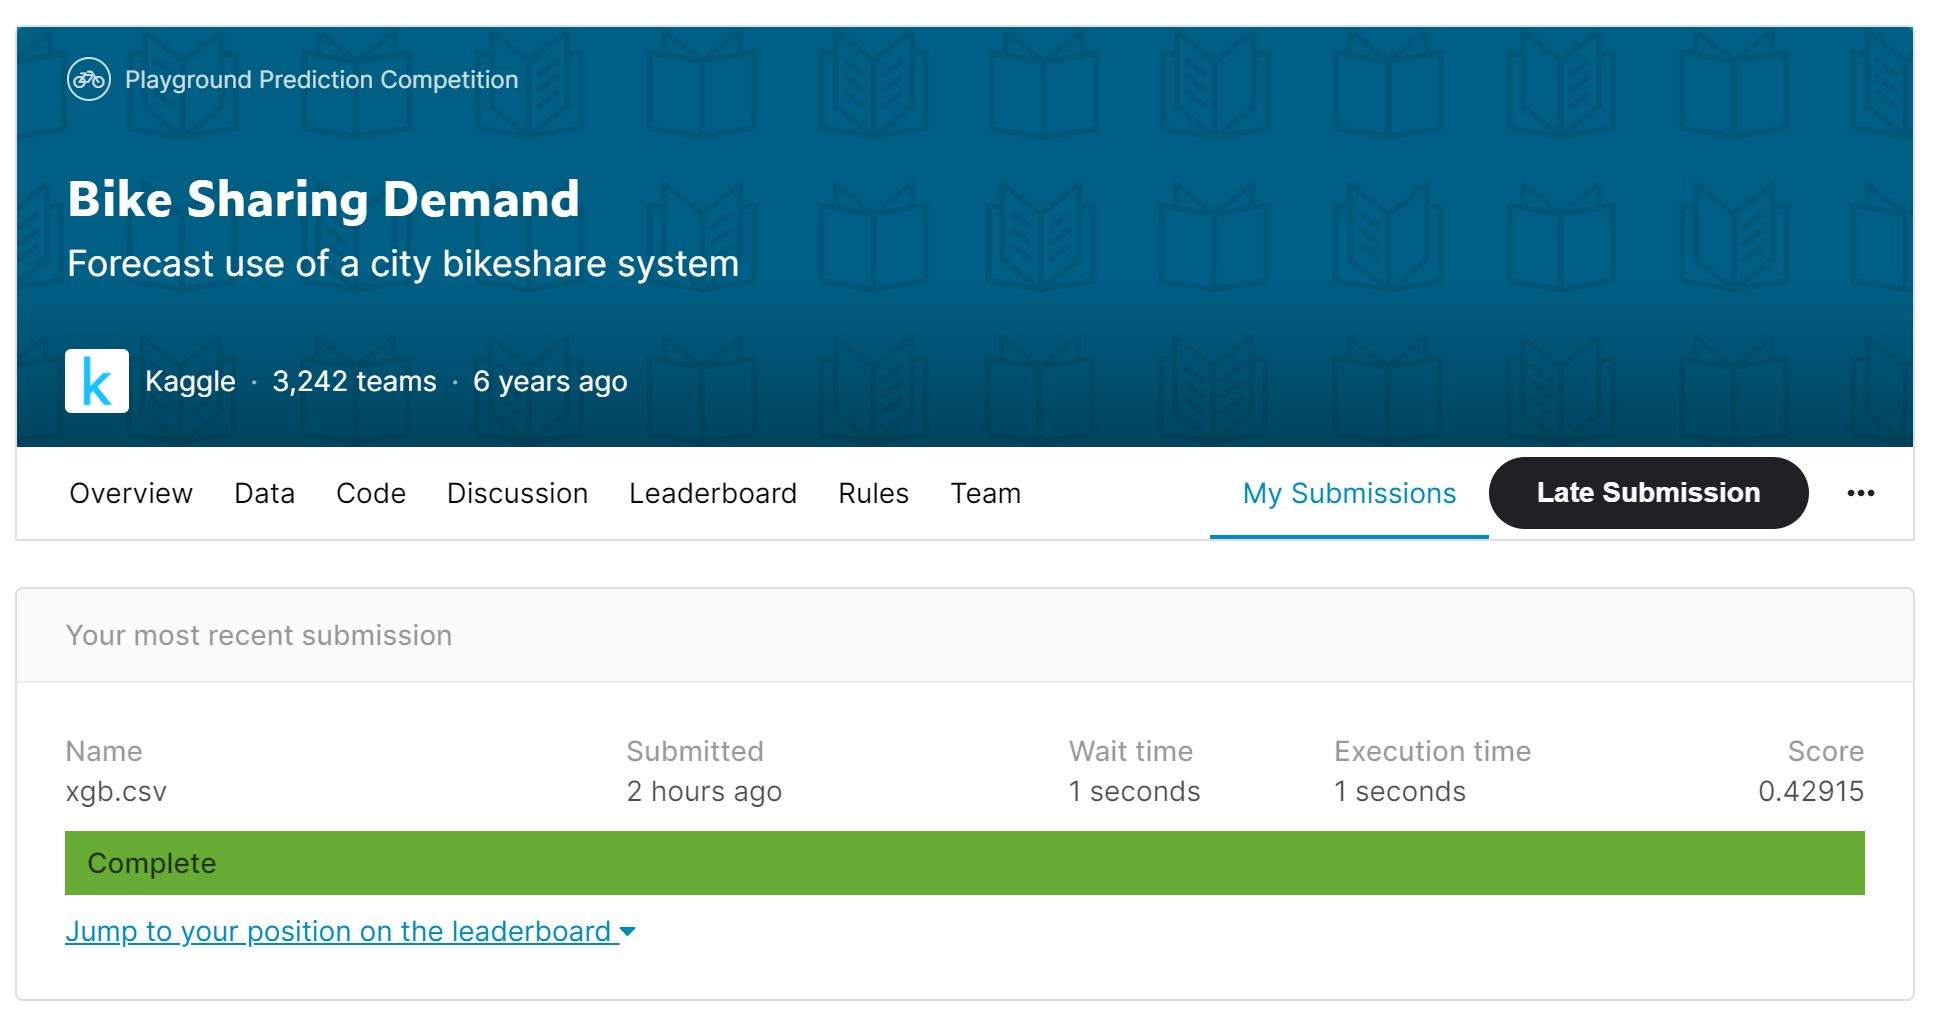

## 새로운거 하나 해보기
- 다른 곳에서 코드를 가져왔더니 예측 확률이 너무 낮아짐

In [116]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 값이 0일 수도 있어서 로그를 취했을 때 마이너스 무한대가 될 수도 있기 때문에 1을 더해 줌
    # 로그를 씌워주는 것은 정규분포로 만들어주기 위해
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

In [119]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 선형회귀 모델을 초기화
lModel = LinearRegression()

# 모델을 학습시킨다.
y_tr_log = np.log1p(y_tr)
lModel.fit(X_tr, y_tr_log)

# 예측하고 정확도를 평가한다.
preds = lModel.predict(X_tr)
print ("RMSLE Value For Linear Regression: ",
       rmsle(np.exp(y_tr_log),np.exp(preds), False))

RMSLE Value For Linear Regression:  0.20805825254820715


릿지

In [121]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_tr_log = np.log1p(y_tr)
grid_ridge_m.fit( X_tr, y_tr_log )
preds = grid_ridge_m.predict(X_tr)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_tr_log),np.exp(preds), False))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

{'alpha': 100, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.20806959869761718


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011862,0.004762,0.001975,0.001049,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-0.202211,-0.219638,-0.208543,-0.208648,-0.203219,-0.208452,0.006189,10
1,0.006997,0.000189,0.000864,0.000106,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-0.202211,-0.219639,-0.208543,-0.208648,-0.203219,-0.208452,0.006189,9
2,0.006740,0.000081,0.000768,0.000029,1,3000,"{'alpha': 1, 'max_iter': 3000}",-0.202208,-0.219640,-0.208543,-0.208647,-0.203217,-0.208451,0.006191,8
3,0.006689,0.000051,0.000775,0.000011,2,3000,"{'alpha': 2, 'max_iter': 3000}",-0.202207,-0.219641,-0.208543,-0.208646,-0.203213,-0.208450,0.006192,7
4,0.006632,0.000061,0.000745,0.000031,3,3000,"{'alpha': 3, 'max_iter': 3000}",-0.202207,-0.219642,-0.208543,-0.208645,-0.203210,-0.208449,0.006193,6


In [123]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_tr_log = np.log1p(y_tr)
rfModel.fit(X_tr, y_tr_log)

preds = rfModel.predict(X_tr)
score = rmsle(np.exp(y_tr_log),np.exp(preds),False)
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.02923544459648404


- 과제: pairplot통해서 temp와 atemp의 다중공산성 확인하기
- 2011년도의 데이터와 2012년도의 데이터가 있었는데 이 경우 2011년도는 자전거 사용서비스가 시작된 연도이기때문에 오히려 2012년도의 데이터를 사용하는게 더 정확도가 높게 나올 수 있다.